<a href="https://colab.research.google.com/github/eitanfass/hydrology-data-science/blob/main/plum%20creek%20watershed%20hydrological%20analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# introduction
In this assignment I will present an analysis of the rain event data near the city of Chicago (Illinois) in the year 2020. The city is located on the shores of freshwater Lake Michigan in the north of the United States.
my analisis will foucs on a small creek near Chicago called Plum creek with a drainage area of 18.7 square miles.  

Precipitation and streamflow data were taken from USGS website, from two different stations the streamflow data station is located 5 km downstream from the precipitation data. Since the percipitation data is collected from the drainage area of the plum creek it can be treated as reflecting the same reality and conditions for both stations. 

### plum creek watershed map

<img align="center" width="500" height="300" src="https://s8.gifyu.com/images/182ef237e13ce7f8b.jpg">

</br>


[sourse](https://www2.illinois.gov/epa/documents/iepa/water-quality/watershed-management/watershed-based-planning/2018/little-calumet/little-calumet-river-wbp.pdf)


In the attached map you can see the watershed for plum creek. The imege also has soil drainege class, we can see that the soils very from somewhat poorly drained to moderately drained.
meaning that in an extream weather event this watershed is in danger of flooding, and plum creek has a history of floods for example on 24.08.2008 there was a flood that generated from this basin and caused about 33 million dollars in dameges
[sourse](https://www.illinoisfloods.org/content/documents/1c_flood_forecasting_watershed_study.pdf).




### 1. importing and orgenizing the data
first let's import all the libraries we will need to use during the data analysis and import our data from the stations:

In [ ]:
import matplotlib.pyplot as plt #importing relevent librarries
import numpy as np
import pandas as pd
from calendar import month_abbr
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)
import urllib.request
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
# Drainage area:18.7 square miles   
data_file = "/content/drive/MyDrive/hydrology/assiment 03/PLUM CREEK_discharge.txt"
df_plum_riv = pd.read_csv(data_file,
                        header=31,                      # no headers needed, we'll do that later
                        delim_whitespace=True,            # blank spaces separate between columns
                        na_values=["Bkw"]  # substitute these values for missing (NaN) values
                )
df_plum_riv.columns = ['agency_cd', 'site_no','datetime','tz_cd','EDT','discharge','code1 _1']                       # rename df columns with headers columns
df_plum_riv['date_and_time'] = df_plum_riv['datetime'] + ' ' + df_plum_riv['tz_cd'] # combine date+time into datetime
df_plum_riv['date_and_time'] = pd.to_datetime(df_plum_riv['date_and_time'])        # interpret datetime
df_plum_riv = df_plum_riv.set_index('date_and_time')                          # make datetime the index
df_plum_riv['discharge'] = df_plum_riv['discharge'].astype(float)
df_plum_riv['discharge'] = df_plum_riv['discharge'] * 0.0283168# convert ft^3/s to m^3/s

data_file = "/content/drive/MyDrive/hydrology/assiment 03/PLUM CREEK_percipitation.txt"
df_plum_per = pd.read_csv(data_file,
                        header=31,                      # no headers needed, we'll do that later
                        delim_whitespace=True,            # blank spaces separate between columns
                        na_values=["Bkw"]  # substitute these values for missing (NaN) values
                )
df_plum_per.columns = ['agency_cd', 'site_no','datetime','tz_cd','EDT','precipitation','code']                       # rename df columns with headers columns
df_plum_per['date_and_time'] = df_plum_per['datetime'] + ' ' + df_plum_per['tz_cd'] # combine date+time into datetime
df_plum_per['date_and_time'] = pd.to_datetime(df_plum_per['date_and_time'])        # interpret datetime
df_plum_per = df_plum_per.set_index('date_and_time')                          # make datetime the index
df_plum_per['precipitation'] = df_plum_per['precipitation'].astype(float)
df_plum_per['precipitation'] = df_plum_per['precipitation'] * 25.4# convert inch/15min to mm/15min


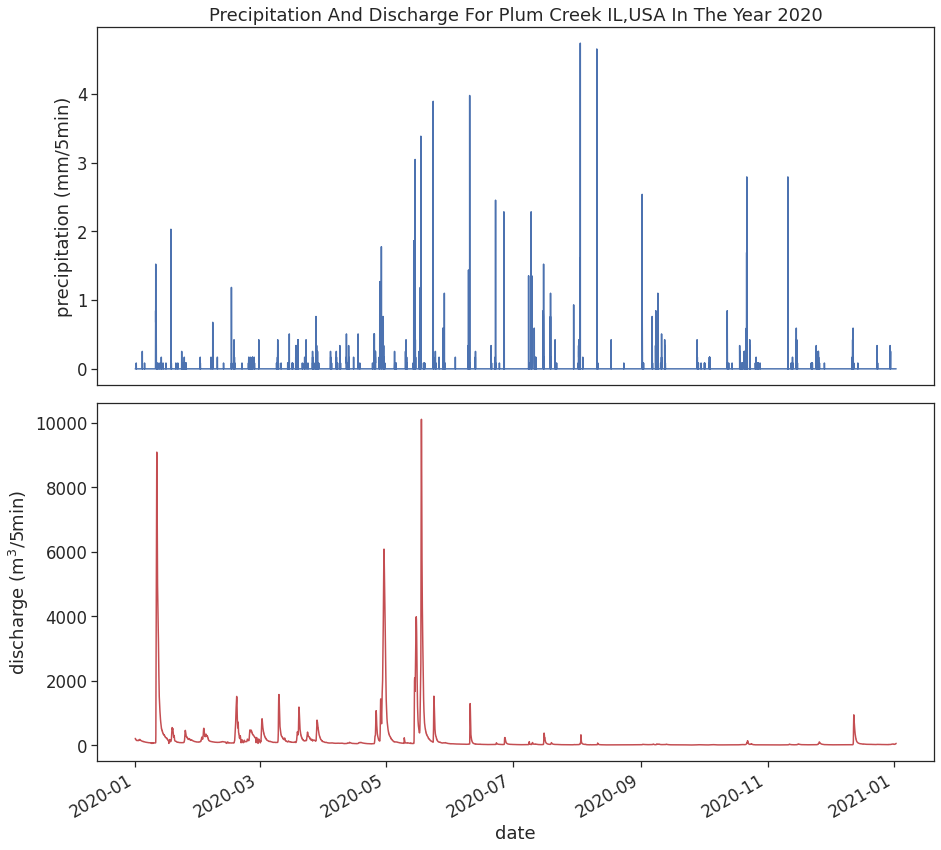

In [ ]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
fig.subplots_adjust(hspace=0.05)

ax1.plot(df_plum_per['precipitation']/3)# our time intervals is 15 min
ax2.plot(df_plum_riv['discharge']*60*5, color="r")


ax1.set(xticks=[],
        ylabel=r"precipitation (mm/5min)",
        title='Precipitation And Discharge For Plum Creek IL,USA In The Year 2020')
ax2.set(xlabel="date",
        ylabel=r"discharge (m$^3$/5min)",
        )

plt.gcf().autofmt_xdate()  # makes slanted dates

This is a representaion of Pulm creeks discharge and percipitation data. From first glance it looks like these graphs dont match, since there are dates with percipitation with no visable discharge data. In order to check if these graphs match i will change the discharge Y scale to log sacle, because the big streamflow are so high they might be shadowing smaller events.

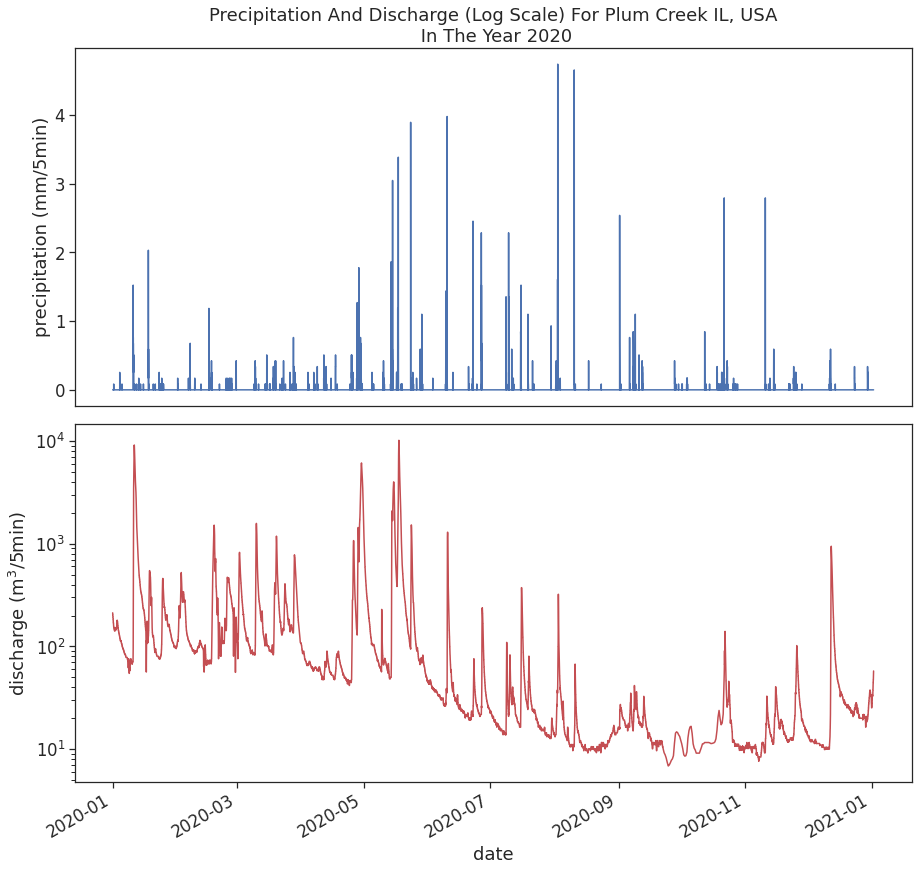

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
fig.subplots_adjust(hspace=0.05)

ax1.plot(df_plum_per['precipitation']/3)# our time intervals is 15 min
ax2.plot(df_plum_riv['discharge']*60*5, color="r")

ax1.set(xticks=[],
        ylabel=r"precipitation (mm/5min)",
         title='Precipitation And Discharge (Log Scale) For Plum Creek IL, USA\n In The Year 2020')

ax2.set(xlabel="date",
        ylabel=r"discharge (m$^3$/5min)",
        yscale="log"
        )

plt.gcf().autofmt_xdate() 

The y axis on the bottom graph is log scale so this way the events are more visable. from looking at the graph above we can notice the percipitation data and stream flow match. 
</br>
### 2. Calculating the rate of effective water input ($p^*$) and the event flow rate ($q^*$).


the rate of effective water input (p*) will give us information on the cumilitive amount of rain that was added to the plum creek river basin douring a specific rain event. not all of this water reach the stream flow dew to ifiltration evaporation and transpiration. 

The calculation of (q*) will help us to separate base flow stream and the flow that came as a result of the rain event.

This parameters can help us to understand our system and her reaction to this rain event.

For my analisis im going to zoom in and analize the a rain event that starts at 11.12.2020 I choose this event since it is reletevly isolated from other rain events and their infloence so i can assume low soil moisture.


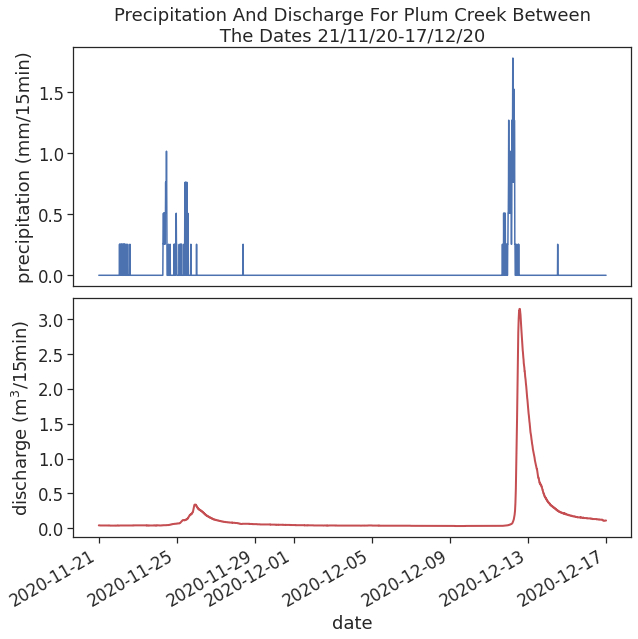

In [ ]:
#collapse-hide

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
fig.subplots_adjust(hspace=0.05)

start = "2020-11-21 00:00:00"
end = "2020-12-17 00:00:00"

ax1.plot(df_plum_per[start:end]['precipitation'])
ax2.plot(df_plum_riv.loc[start:end]['discharge'], color="r", lw=2)

ax1.set(xticks=[],
        ylabel=r"precipitation (mm/15min)",
        title='Precipitation And Discharge For Plum Creek Between\n The Dates 21/11/20-17/12/20 ')
ax2.set(xlabel="date",
        ylabel=r"discharge (m$^3$/15min)")

plt.gcf().autofmt_xdate()  # makes slanted dates

the graph above is a zoom in on our rain event, we can see it is about 17 days away from the last sugnificant rain event. In the next graph I will zoom in closer to our event and convert the units to SI units and calculate the total rainfall $P^*$ and total discharge $Q^*$, both in $m^3$.

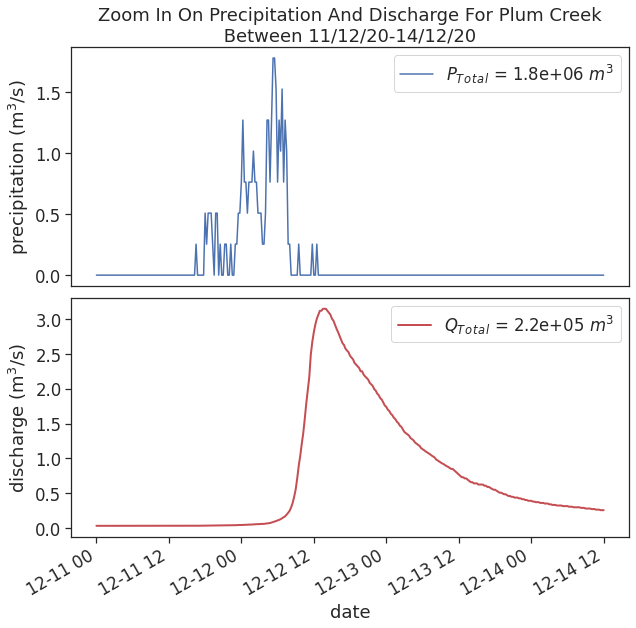

In [ ]:
# plum creek drainage area:  18.7 square miles 
start = "2020-12-11 00:00:00"
end = "2020-12-14 12:00:00"
area = 18.7 * 2589988.10  # squared miles to squared meters

df_p = df_plum_per.loc[start:end]['precipitation'].to_frame()
#df_p_mm = df_plum_per.loc[start:end]['PRECIPITATION'].to_frame()
df_q = df_plum_riv.loc[start:end]['discharge'].to_frame()

df_p['precipitation'] = df_p['precipitation'] * area / 1000  # mm to m3 in the whole watershed
df_p['precipitation'] = df_p['precipitation'] /60/15 # convert m3 per 15 min to m3/s
P = df_p['precipitation'].sum()*60*15 
Q = df_q['discharge'].sum()*60*15 

# print("total precipitation during event: Pstar = {:.1e} m3".format(P.sum()))
# print("total streamflow during event: Qstar = {:.1e} m3".format(Q.sum()))


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
fig.subplots_adjust(hspace=0.05)


ax1.plot(df_plum_per[start:end]['precipitation'],label = "$P_T$$_o$$_t$$_a$$_l$ = {:.1e} $m^3$".format(P.sum()))
ax2.plot(df_plum_riv.loc[start:end]['discharge'], color="r", lw=2,label = "$Q_T$$_o$$_t$$_a$$_l$ = {:.1e} $m^3$".format(Q.sum()))

ax1.set(xticks=[],
        ylabel=r"precipitation (m$^3$/s)",
        title='Zoom In On Precipitation And Discharge For Plum Creek\n Between 11/12/20-14/12/20 ')
ax2.set(xlabel="date",
        ylabel=r"discharge (m$^3$/s)")

plt.gcf().autofmt_xdate()  # makes slanted dates
ax1.legend()
ax2.legend();

The delay in the discharge graph from the percipitation makes a lot of sense because it takes time for the runoff to start and reach the water shed exit (this time will be caculatd later). Now I will separate the base flow from the effective flow that follows as a result of this rain event. I will call that the effective flow Q* and the total flow amount (including base flow) is Q

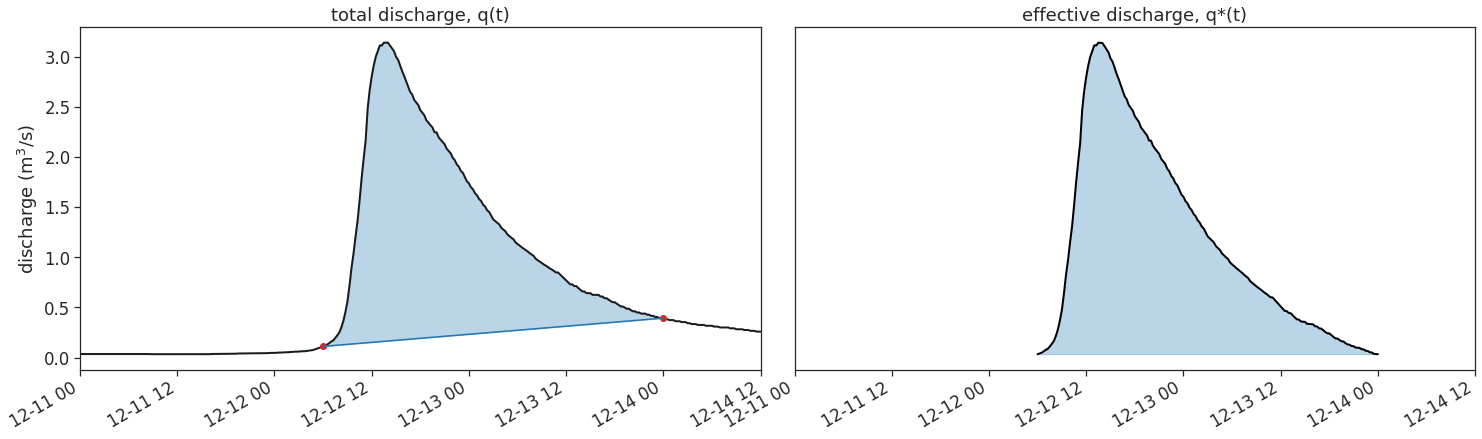

In [ ]:
from matplotlib.dates import HourLocator, DateFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,7))
fig.subplots_adjust(wspace=0.05)

start = "2020-12-12 06:00:00"
end = "2020-12-14 00:00:00"

ax1.plot(df_q['discharge'], color="k", lw=2)
point1 = pd.to_datetime(start)
point2 = pd.to_datetime(end)
two_points = df_q.loc[[point1, point2]]['discharge']
ax1.plot(two_points, 'o', color="tab:red")

new = pd.DataFrame(data=two_points, index=two_points.index)

df_linear = (new.resample("15min") #resample
                .interpolate(method='time') #interpolate by time
            )

ax1.plot(df_linear, color="tab:blue")


df_between_2_points = df_q.loc[df_linear.index]


ax1.fill_between(df_between_2_points.index, df_between_2_points['discharge'],
                 y2=df_linear['discharge'],
                 color="tab:blue", alpha=0.3)

qstar = df_q.loc[df_linear.index]['discharge'] - df_linear['discharge']
Qstar = qstar.sum() *60*15

ax2.plot(qstar, color="black", lw=2)
ax2.fill_between(qstar.index, qstar,
                 y2=0.0,
                 color="tab:blue", alpha=0.3)

ax1.set(xlim=[df_q.index[0],
              df_q.index[-1]],
        
        ylabel=r"discharge (m$^3$/s)",
        title="total discharge, q(t)")
ax2.set(yticks=[],
        
        xlim=[df_q.index[0],
              df_q.index[-1]],
        title="effective discharge, q*(t)"
       )

plt.gcf().autofmt_xdate()  # makes slated dates


Now we can calculate p*, using

$$
P^* = Q^*
$$


One of the simplest methods is to multiply $p(t)$ by a fixed constant (<1) to obtain $p^*$,so that the equation above holds true, the constent is callculated like this:
$$
Q^*/P=ratio
$$
$$
P^*=P*ratio
$$

This is the simplest method but probably the least accurate. It is assumed that there is always a constant percentage of rain that becomes discharge for every river basin. In practice the reality is probably more complex since factors such as soil depth, initial moisture content, soil type, etc. must be taken into account. For the purpose of our discussion I will use this simple model.
[source 1](https://yairmau.github.io/website/markdown/2020/02/05/unit-hydrograph-lecture.html) [source 2](https://yairmau.github.io/website/jupyter/2020/02/05/streamflow-exercises.html)

In [ ]:
ratio = Qstar/ P
pstar = df_p['precipitation'] * ratio
Pstar = pstar.sum() * 15 * 60
print(f"Qstar / P = {ratio:.3f}")

Qstar / P = 0.094


lets summerize our findings in a chart:

|Parameter  | value (m$^3$/s) |
| --- | --- |
|$ P $  |1.76$*10^6$ |
|$ P^*$ | 1.6$*10^5$|
|$ Q$  | 2.2$*10^5$ |
|$ Q^*$   | 1.6$*10^5$|

$ratio=0.094$ 

this means that 9.4% of the rain fall in this event turned up in the streamflow.
offcorse this ratio is a representation of only one rain fall event and it is not a perfect representation of our river basin behavior.
to get a better understanding we wold need to do the same caculations to more rain event and average them to get a better ratio for this river basin.
For our analisis this ratio will be good enaugh.

### 2. Calculating importent time parameters
Now lets calcultes some parameters of time. They will help us to understand our system and the reaction to a rain event. Although it is necessary to know additional parameters (initial moisture content for example) these times will help us to generally characterize the watershade of plum creek:

1. The centroid ($t_pc$) for effective precipitation p* and centroid ($t_{qc}$) of effective discharge q*.
   The center of mass is like a weighted average. Each statistic is given value in relation to its contribution to precipitation in the weighting of time

2. The time of peak discharge ($t_{pk}$)

3. The centroid lag ($T_{LC}$), the centroid lag-to-peak ($T_{LPC}$). 

4. The time of concentration ($T_c$)

These data will show us the "reaction time" of the system to the rain. This time is a characteristic that is important to know for example when planning the municipal drainage system or when preparing for extreme precipitation events.

We will use the equations below:

$T_{LPC} \simeq 0.60 \cdot T_c$

Time of precipitation centroid:

$$
t_{pc} = \frac{\displaystyle \sum_{i=1}^n p_i^* \cdot t_i}{P^*}
$$

Time of streamflow centroid:

$$
t_{qc} = \frac{\displaystyle \sum_{i=1}^n q_i^* \cdot t_i}{Q^*}
$$


Centroid lag:

$$
T_{LC} = t_{qc} - t_{pc}
$$

Centroid lag-to-peak:
$$
T_{LPC} = t_{pk} - t_{pc}
$$


Time of concentration:
$$
T_{LPC} \simeq 0.60 \cdot T_c
$$

In [ ]:

# pstar centroid
# time of the first (nonzero) rainfall data point
t0 = pstar[pstar != 0.0].index[0]
# time of the last (nonzero) rainfall data point
tf = pstar[pstar != 0.0].index[-1]
# duration of the rainfall event, in minutes
td = (tf-t0) / pd.Timedelta('1 min')
# make time array, add 2.5 minutes (half of dt)
time = np.arange(0, td+1, 15) + 7.5
# create pi array, only with relevant data (during rainfall duration)
pi = pstar.loc[(pstar.index >= t0) & (pstar.index <= tf)]
# convert from m3/5min to m3/s
pi = pi.values * 60 * 15
# time of precipitation centroid
t_pc = (pi * time).sum() / pi.sum()
# add initial time
t_pc = t0 + pd.Timedelta(minutes=t_pc)

# qstar centroid
# time of the first (nonzero) discharge data point
t0 = qstar[qstar != 0.0].index[0]
# time of the last (nonzero) discharge data point
tf = qstar[qstar != 0.0].index[-1]
# duration of the discharge event, in minutes
td = (tf-t0) / pd.Timedelta('1 min')
# make time array, add 7.5 minutes (half of dt)
time = np.arange(0, td+1, 15) + 7.5
# create qi array, only with relevant data (during discharge duration)
qi = qstar.loc[(qstar.index >= t0) & (qstar.index <= tf)]

qi = qi.values
# time of discharge centroid
t_qc = (qi * time).sum() / qi.sum()
# add initial time
t_qc = t0 + pd.Timedelta(minutes=t_qc)
t_qc

# time of peak discharge
max_discharge = qstar.max()
t_pk = qstar[qstar == max_discharge].index[0]

# centroid lag
T_LC = t_qc - t_pc

# centroid lag-to-peak
T_LPC = t_pk - t_pc

# time of concentration
T_c = T_LPC / 0.60

print(f"T_LC = {T_LC}")
print(f"T_LPC = {T_LPC}")
print(f"T_c = {T_c}")

T_LC = 0 days 17:31:34.314895
T_LPC = 0 days 10:22:17.412587
T_c = 0 days 17:17:09.020978333


36.32200000000001

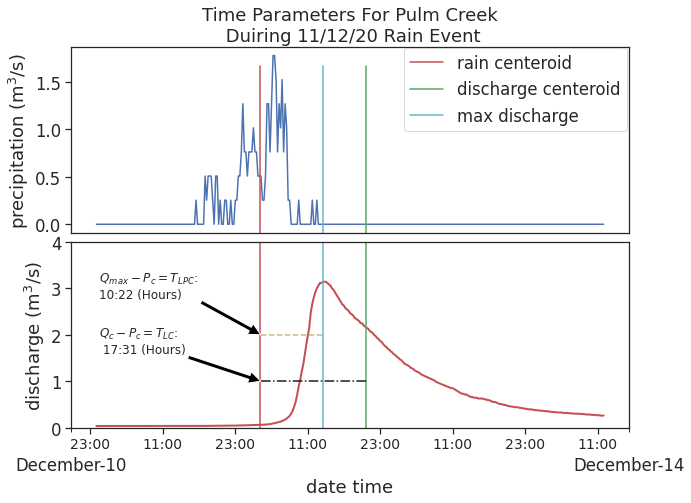

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,7))
fig.subplots_adjust(hspace=0.05)

start = "2020-12-11 00:00:00"
end = "2020-12-14 12:00:00"

#the data
df_plum_per['precipitation']
ax1.plot(df_plum_per[start:end]['precipitation'])


ax1.set(xticks=[],ylabel=r"precipitation (m$^3$/s)",
        title='Time Parameters For Pulm Creek\n Duiring 11/12/20 Rain Event')
#vertical lines
ax1.axvline(t_pc,ymin=0,ymax=0.9,color='r')
ax1.axvline(t_qc,ymin=0,ymax=0.9,color='g')
ax1.axvline(t_pk,ymin=0,ymax=0.9,color='c')


#the data
ax2.plot(df_plum_riv[start:end]['discharge'], color="r", lw=2)

#parameters
ax2.set(xlabel="date time",
        ylabel="discharge (m$^3$/s)")

#vertical lines
ax2.axvline(t_pc,ymin=0,ymax=1,color='r',label="rain centeroid")
ax2.axvline(t_qc,ymin=0,ymax=1,color='g',label="discharge centeroid")
ax2.axvline(t_pk,ymin=0,ymax=1,color='c',label="max discharge")
ax2.set(ylim=(0,4))
#horizontal lines
ax2.axhline(2,xmin=0.34,xmax=0.45,color="y",ls="--")
ax2.axhline(1,xmin=0.34,xmax=0.53,color="k",ls="-.")

#arrows
ax2.annotate(f"$Q_m$$_a$$_x-P_c = T_L$$_P$$_C$:\n10:22 (Hours)",
             xycoords='axes fraction',
             xy=(0.34,0.5),
             xytext=(0.05,0.7),
             fontsize=12,
             arrowprops=dict(facecolor='black',))
ax2.annotate(f"$Q_c-P_c = T_L$$_C$:\n 17:31 (Hours)",
             xycoords='axes fraction',
             xy=(0.34,0.25),
             xytext=(0.05,0.4),
             fontsize=12,
             arrowprops=dict(facecolor='black',))


#date ticks
ax2.xaxis.set_minor_locator(mdates.WeekdayLocator())
ax2.xaxis.set_minor_formatter(mdates.DateFormatter('\n%B-%d'))

#hour ticks
ax2.xaxis.set_major_locator(mdates.HourLocator(interval = 12))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


plt.xticks(fontsize=14)
fig.legend(bbox_to_anchor=(0.882, 0.92))
H=P/area
H*1000

The above graph is for visualzation of the time parameters caculated in this rain event. 
# Discussion
In this assignment I took a closer look into river baison reaction to precipitation, and spesificly at the water flow during a rain event that ocurred in Plum creek, IL, USA 10-14/12/2022. I collected precipitation and dischage data from the USGS website. so far we have found the flowing pramers for this rain event:
        
|Parameter  | value (m$^3$/s) |
| --- | --- |
|$ P $  |1.76$*10^6$ |
|$ P^*$ | 1.6$*10^5$|
|$ Q$  | 2.2$*10^5$ |
|$ Q^*$   | 1.6$*10^5$|


As calculated, the ratio for $Q^*/P=0.094$  this means that in our rainfall event only 9.4% of precipitation ended up downstream in the Pulm creek hydrology measuring station.From this we can understand that 90.6% of the percipitaion that landed on the river basin was cunsume by the envierment around Pulm creek. If we divide the total precipitation by the basin area we will get the hight of the water that was counsumed by the envierment: $P/area=36.3mm$  
So the enviorment consumed 36.3mm of water in about 24 hours. where did the water go?</br> Pulm creeks river basin consist of 2 main landcovers:
1. nature reserve and forest 
2. agricultural fields
these land coves are big water consumers, some water is pooled in pools along the creek and then used to water the nearby agricultural fields. The nature reserve and forest also consume water throw plant transpiration and ponds located in the nature reserve.

The initial moisture content of the soil before the rain event has a big infloence on the strength of the sreamflow, the ground acts as a buffer and delayes the run off. The wetter the soil the faster a surface runoff will form. From the annual precipitation graph created at the beginning it can be seen that the rain event prior to the event we analyzed was 17 days earlier. It can be assumed that the moisture content in the soil decreasedand this can also explain to us the fact that 90 percent of the rain did not reach the stream flow.
</br>
**Time parameters**

|Time Parameter  |Value (Hours) |
| --- | --- |
|$ T_P$$_C $  |17:31 |
|$ T_P$$_L$$_C $  | 10:22|
|$ T_c$  | 17:17 |

These times can help us understand how our system in Pulm creek responds to rain events.

- $ T_P$$_C $ represents the time between the center of mass of the rain and the center of mass of the discharge. The greater this time it means that the response signal is more moderate, meaning it took longer for the water to become a surface runoff.
- $ T_P$$_L$$_C $ represents the time elapsed between the center of mass precipitation and the peak measured at the rate of flow of the stream. Its an important measure of the system's response to a rain event. The longer this time, the more moderate the flow will be.

- $ T_C$ Represents "concentration time". It is defined as the time needed for water to flow from the most remote point in a watershed to the watershed outlet.

The response times of the system indicate the same trends that we calculated using the above parameters: the factors that create infiltration and slow surface runoff (agricultural, vegetation, etc.) have a stronger effect than the factors that encourage rapid and immediate rate of surface runoff. Since we chose a relatively simple model and implimented it on just one rain event  my time parameters and ratio are not based on enaugh data and there for not so reliable.
